In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [4]:
import numpy as np

In [97]:
from coniferest.pineforest import PineForest, Coniferest, PineForestAnomalyDetector
from coniferest.experiment import AnomalyDetectionExperiment
from coniferest.datasets import MalanchevDataset, Dataset
from coniferest.datasets import Label
import matplotlib.pyplot as plt

from coniferest.utils import average_path_length

In [119]:
class LarchForest(PineForest):
    def __init__(self, *args, sampling_fraction=0.9, **kwargs):
        super().__init__(*args, **kwargs)
        self.bounds = None
        self.sampling_fraction = sampling_fraction
    
    def fit_known(self, data, known_data=None, known_labels=None):
        self.bounds = np.stack((np.min(data, axis=0), np.max(data, axis=0)), axis=0)
        return super().fit_known(data, known_data, known_labels)
    
    def sample(self, n_samples, downsample_ratio=1):
        x = self.sample_subuniform(n_samples * downsample_ratio)
        scores = (-self.score_samples(x)) ** (-average_path_length(self.n_subsamples))
        scores /= scores.sum()
        index = np.random.choice(x.shape[0], size=n_samples, p=scores)
        return x[index]
    
    def sample_subuniform(self, n_samples=1):
        return np.stack([self._sample_subuniform() for _ in range(n_samples)], axis=0)
    
    def _sample_subuniform(self):
        tree = np.random.choice(self.trees)

        node = 0
        bounds = self.bounds.copy()
        while tree.feature[node] >= 0:
            if np.random.rand() > 0.5:
                bounds[0, tree.feature[node]] = tree.threshold[node]
                node = tree.children_right[node]
            else:
                bounds[1, tree.feature[node]] = tree.threshold[node]
                node = tree.children_left[node]
        
        return np.random.uniform(*bounds)
    
    def _expand_trees(self, data, n_trees):
        n = n_trees - len(self.trees)
        if n <= 0:
            return
        
        if len(self.trees) == 0:
            return super()._expand_trees(data, n_trees)

        new_data_size = n * self.n_subsamples
        sampled_data_size = int(np.round(new_data_size * self.sampling_fraction))        
        sampled_data = self.sample(sampled_data_size)
        
        original_data_size = new_data_size - sampled_data_size
        original_index = np.random.choice(data.shape[0], original_data_size)
        original_data = data[original_index]
        
        new_data = np.concatenate([sampled_data, original_data])
        assert new_data.shape == (new_data_size, data.shape[1])
        np.random.shuffle(new_data)
        new_data = new_data.reshape((n, self.n_subsamples, -1))
        
        for subsamples in new_data:
            tree = self.build_one_tree(subsamples)
            self.trees.append(tree)

In [95]:
d = MalanchevDataset()

f = LarchForest()
f.fit_known(d.data)
f.fit_known(d.data, np.array([[0, 1], [1, 1], [1, 0]]), np.array([1, 1, -1]))

In [109]:
pineforest = PineForest()
pineforest_det = PineForestAnomalyDetector(pineforest)
pineforest_exp = AnomalyDetectionExperiment(pineforest_det, d.data, d.labels, capacity=50)
pineforest_exp.run(tqdm=True)

 76%|███████▌  | 38/50 [00:02<00:00, 15.32it/s]


array([1032, 1056, 1101, 1110, 1113, 1108, 1088, 1096, 1099, 1106, 1100,
       1034, 1090, 1089, 1112, 1115, 1118, 1092, 1114, 1102, 1105, 1119,
       1107, 1095, 1091, 1116, 1117, 1038, 1098, 1104, 1093, 1103, 1044,
       1097, 1111, 1054, 1094, 1109])

In [127]:
larchforest = LarchForest(n_trees=300, n_spare_trees=700, sampling_fraction=0.9)
larchforest_det = PineForestAnomalyDetector(larchforest)
larchforest_exp = AnomalyDetectionExperiment(larchforest_det, d.data, d.labels, capacity=50)
larchforest_exp.run(tqdm=True)

 88%|████████▊ | 44/50 [08:29<01:09, 11.58s/it]


array([1101, 1056, 1106, 1100, 1114, 1038, 1091, 1102, 1096, 1032, 1116,
       1090, 1026, 1107, 1098, 1117, 1110, 1088, 1104, 1103, 1115, 1118,
       1095, 1099, 1108, 1034, 1097, 1093, 1112, 1030, 1092, 1113, 1111,
       1036, 1089, 1094, 1109, 1044, 1042, 1105, 1043, 1037, 1031, 1119])

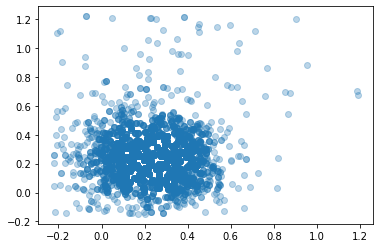

In [128]:
plt.scatter(*larchforest.sample(5000).T, alpha=0.3)

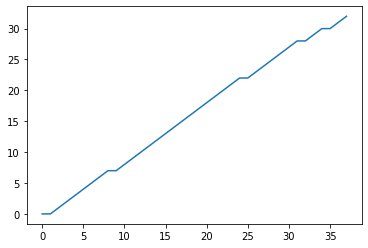

In [126]:
plt.plot(np.cumsum(larchforest_exp.data_labels[larchforest_exp.trajectory] == Label.A))

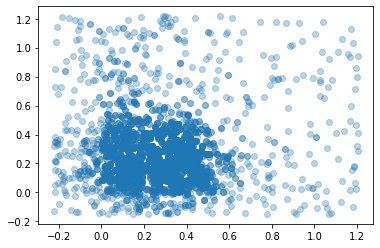

In [91]:
plt.scatter(*f.sample(5000).T, alpha=0.3)

In [71]:
[].extend([1, 2, 3])

In [23]:
t.feature

array([ 1,  1,  1, -2,  0, -2, -2,  0,  1,  1,  1,  0,  0, -2, -2,  0, -2,
       -2,  1,  0, -2, -2,  0, -2, -2,  1,  0,  0, -2, -2,  0, -2, -2,  1,
        1, -2, -2,  1, -2, -2,  1,  1,  0,  1, -2, -2,  0, -2, -2,  0,  1,
       -2, -2, -2,  0, -2, -2,  0, -2,  0,  1,  1, -2, -2,  0, -2,  0, -2,
       -2,  0,  1, -2,  0, -2, -2, -2, -2], dtype=int64)

In [24]:
t.threshold

array([ 1.21822713, -0.06367152, -0.1299281 , -2.        ,  1.00676977,
       -2.        , -2.        ,  0.75750398,  0.44349682,  0.32930177,
        0.17311524,  0.46568282,  0.13805894, -2.        , -2.        ,
        0.49266349, -2.        , -2.        ,  0.25270519,  0.38485362,
       -2.        , -2.        ,  0.02718685, -2.        , -2.        ,
        0.35763308,  0.31615002,  0.07202486, -2.        , -2.        ,
        0.43335402, -2.        , -2.        ,  0.42437382,  0.4016628 ,
       -2.        , -2.        ,  0.43247034, -2.        , -2.        ,
        1.07531855,  0.73056681,  0.12283174,  0.47808779, -2.        ,
       -2.        ,  0.40958337, -2.        , -2.        ,  0.09592013,
        1.05700373, -2.        , -2.        , -2.        , -0.02707394,
       -2.        , -2.        ,  0.80179037, -2.        ,  0.99943956,
        0.1928381 ,  0.0686626 , -2.        , -2.        ,  0.89724245,
       -2.        ,  0.97061679, -2.        , -2.        ,  1.03

In [26]:
t.n_node_samples

array([256, 255,   3,   1,   2,   1,   1, 252, 242, 216, 161,  94,  87,
        23,  64,   7,   6,   1,  67,  36,  25,  11,  31,   2,  29,  55,
        12,   7,   4,   3,   5,   4,   1,  43,  35,  20,  15,   8,   2,
         6,  26,  24,  20,   5,   3,   2,  15,  12,   3,   4,   3,   1,
         2,   1,   2,   1,   1,  10,   1,   9,   5,   2,   1,   1,   3,
         1,   2,   1,   1,   4,   3,   1,   2,   1,   1,   1,   1],
      dtype=int64)

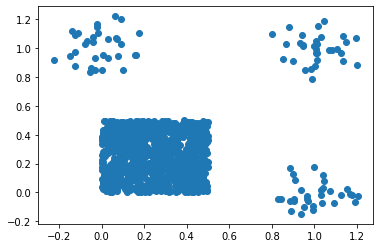

In [12]:
plt.scatter(*d.data.T)